In [2]:
import psycopg2
import pandas as pd
from psycopg2.extras import execute_values

In [3]:
# connexion BDD
host = "localhost"
database = "DB_SUPERSTORE"
user = "postgres"
password = "root"

conn = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password
)

In [4]:
# Créer un curseur
cur = conn.cursor()

# Exécuter une requête SQL
cur.execute("SELECT * FROM s_superstore.tb_superstore")
data = cur.fetchall()

# Transformer les résultats en DataFrame Pandas
df = pd.DataFrame(data, columns=["order_id","order_date","ship_date","ship_mode","customer_id","customer_name","segment","country","city","state","postal_code","region","product_id","category","sub_category","product_name","sales","quantity","discount","profit"])

<AxesSubplot:>

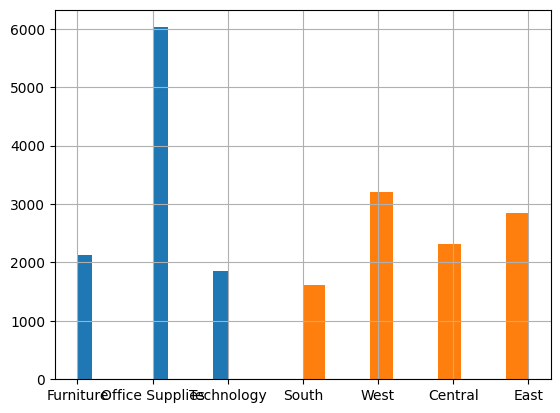

In [5]:
df['category'].hist()
df['region'].hist()

In [6]:
# Supprimer les lignes sans valeur sales
df = df.dropna(subset=["quantity"]) #Avec cette modification on a maintant 9987 lignes

# Définir le type de chaque colonne
df['order_id'] = df['order_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])
df['ship_mode'] = df['ship_mode'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['customer_name'] = df['customer_name'].astype(str)
df['segment'] = df['segment'].astype(str)
df['country'] = df['country'].astype(str)
df['city'] = df['city'].astype(str)
df['state'] = df['state'].astype(str)
df['postal_code'] = df['postal_code'].astype(str)
df['region'] = df['region'].astype(str)
df['product_id'] = df['product_id'].astype(str)
df['category'] = df['category'].astype(str)
df['sub_category'] = df['sub_category'].astype(str)
df['product_name'] = df['product_name'].astype(str)
df['sales'] = df['sales'].astype(float)
df['quantity'] = df['quantity'].astype(int)
df['discount'] = df['discount'].astype(float)
df['profit'] = df['profit'].astype(float)

In [7]:
# Identifier les produits avec des ID dupliqués
duplicate_product_id = df.groupby('product_id')['product_name'].nunique()
products_with_duplicates = duplicate_product_id[duplicate_product_id > 1].index #Liste des product_id avec deux noms

# Mettre à jour les ID des produits en doublon
for product_id in products_with_duplicates:
    # Récupérer toutes les lignes avec cet ID de produit
    rows_with_duplicate_id = df.loc[df['product_id'] == product_id]
    
    # Identifier les lignes avec le deuxième nom de produit
    second_product_names = rows_with_duplicate_id['product_name'].value_counts().index[1:]
    
    # Mettre à jour l'ID des lignes avec le deuxième nom de produit
    for product_name in second_product_names:
        rows_to_update = rows_with_duplicate_id.loc[rows_with_duplicate_id['product_name'] == product_name]
        new_product_id = f"{product_id}2"
        for i, row in rows_to_update.iterrows():
            df.at[i, 'product_id'] = new_product_id #Maintenant on a 1893 produit différents

# Calculer le prix unitaire en utilisant la formule : sales / (quantity * (1 - discount))
df['unit_price'] = (df['sales'] / (df['quantity'] * (1 - df['discount']))).round(2)

# Identifier les produits avec le même nom
# Liste des produits avec le même nom mais des ID différents et de catégory ou sub cat différentes
diff_id = df.loc[df.groupby('product_name')['product_id'].transform('nunique') == 2].copy()
#On utilise == 2 parce qu'apès analyse on a remarqué que seul ceux avec 2 ID sont identiques
diff_id = diff_id[diff_id.groupby('product_name')['unit_price'].transform('nunique') == 1]
df.loc[diff_id.index, 'product_id'] = diff_id.groupby('product_name')['product_id'].transform('first')

# Arrondi profit
df['profit']=df['profit'].round(2)


df.describe()

,sales,quantity,discount,profit,unit_price
count,9987.000000,9987.000000,9987.000000,9987.000000,9987.000000
mean,229.797993,3.788825,0.156182,28.637213,75.560120
std,623.453932,2.225016,0.206511,234.339100,189.023502
min,0.444000,1.000000,0.000000,-6599.980000,0.990000
25%,17.248000,2.000000,0.000000,1.730000,6.480000
50%,54.368000,3.000000,0.200000,8.640000,19.980000
75%,209.836000,5.000000,0.200000,29.340000,76.980000
max,22638.480000,14.000000,0.800000,8399.980000,7546.160000


In [8]:
# Création de Product
list = ['product_id','product_name', 'category', 'sub_category', 'unit_price']
product = df[list]

# Supprimer les product_id en double pour avoir des valeur unique dans la dimension
product = product.drop_duplicates(subset="product_id")
product.describe() # On se rerouve avec 1886 produits différents

product['product_id'] = df['product_id'].astype(str)
product['category'] = df['category'].astype(str)
product['sub_category'] = df['sub_category'].astype(str)
product['product_name'] = df['product_name'].astype(str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 9933
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    1886 non-null   object 
 1   product_name  1886 non-null   object 
 2   category      1886 non-null   object 
 3   sub_category  1886 non-null   object 
 4   unit_price    1886 non-null   float64
dtypes: float64(1), object(4)
memory usage: 88.4+ KB


In [9]:
# Creation customer
list = ['customer_id','customer_name', 'segment','region', 'state', 'city', 'postal_code']
customer = df[list]

#Supprimer les valeurs en double
customer = customer.drop_duplicates(subset="customer_id")
#customer.describe()

In [10]:
# Creation de Order
to_drop = ['customer_name', 'segment', 'country', 'city', 'state', 'postal_code','region', 'category', 'sub_category', 'product_name', 'unit_price']
order = df.drop(columns=to_drop)

In [11]:
# Insérer les données du dataframe dans la table s_superstore.tb_customer
cursor = conn.cursor()
for index, row in customer.iterrows():
    sql = "INSERT INTO s_superstore.tb_customer (customer_id, customer_name, segment, region, state, city, postal_code) VALUES (%s, %s, %s, %s, %s, %s, %s)"
    values = (row['customer_id'], row['customer_name'], row['segment'], row['region'], row['state'], row['city'], row['postal_code'])
    cursor.execute(sql, values)

conn.commit()

UniqueViolation: ERREUR:  la valeur d'une clé dupliquée rompt la contrainte unique « TB_CUSTOMER »
DETAIL:  La clé « (customer_id)=(CG-12520) » existe déjà.


In [ ]:
# Insérer les données du dataframe dans la table s_superstore.tb_product
cursor = conn.cursor()
for index, row in product.iterrows():
    sql = "INSERT INTO s_superstore.tb_product (product_id, product_name, category, sub_category, unit_price) VALUES (%s, %s, %s, %s, %s)"
    values = (row['product_id'], row['product_name'], row['category'], row['sub_category'], row['unit_price'])
    cursor.execute(sql, values)

conn.commit()

In [ ]:
# Insérer les données du dataframe dans la table s_superstore.tb_order
cursor = conn.cursor()
for index, row in order.iterrows():
    sql = "INSERT INTO s_superstore.tb_order (order_id, order_date, ship_date, ship_mode, customer_id, product_id, sales, quantity, discount, profit) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    values = (row['order_id'], row['order_date'], row['ship_date'],row['ship_mode'], row['customer_id'], row['product_id'], row['sales'], row['quantity'], row['discount'], row['profit'])
    cursor.execute(sql, values)

conn.commit()
cursor.close()
conn.close()